# DSA210 Project Part 2
- Toprak Babacan
- 31156
- 23.04.2025

# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from IPython.display import display

# Data Preparation & merging 
- Loaded the datasets(health expenditure, measles, and diphtheria) and processed it accordingly.
- Filtered the years 2000–2019 
- Merged them into a single structured DataFrame using country and year as keys.

In [2]:
# loading datasets
health_df = pd.read_csv("health_expenditure.csv", skiprows=4)
country_meta_df = pd.read_csv("metadata_health_expenditure.csv")
measles_df = pd.read_csv("kızamık.csv")
diphtheria_df = pd.read_csv("difteri.csv", encoding="ISO-8859-1")

# filtering health data for years 2000–2019
health_long = health_df.melt(
    id_vars=["Country Name", "Country Code"],
    value_vars=[str(year) for year in range(2000, 2020)],
    var_name="Year",
    value_name="Health_Expenditure_%GDP"
)

# filtering measles and diphtheria data for 2000–2019
measles_df = measles_df[measles_df["Period"].between(2000, 2019)]
diphtheria_df = diphtheria_df[diphtheria_df["Period"].between(2000, 2019)]

# renaming the columns for merging
measles_df = measles_df.rename(columns={"Location": "Country Name", "Period": "Year", "Value": "Measles_Cases"})
diphtheria_df = diphtheria_df.rename(columns={"Location": "Country Name", "Period": "Year", "Value": "Diphtheria_Cases"})

# all year columns to int type
health_long["Year"] = health_long["Year"].astype(int)
measles_df["Year"] = measles_df["Year"].astype(int)
diphtheria_df["Year"] = diphtheria_df["Year"].astype(int)

# merge health with measles
merged = pd.merge(health_long, measles_df[["Country Name", "Year", "Measles_Cases"]],
                  on=["Country Name", "Year"], how="inner")

# merge with diphtheria
merged = pd.merge(merged, diphtheria_df[["Country Name", "Year", "Diphtheria_Cases"]],
                  on=["Country Name", "Year"], how="inner")

# add metadata
merged = pd.merge(merged, country_meta_df[["TableName", "Region", "IncomeGroup"]],
                  left_on="Country Name", right_on="TableName", how="left")
merged.drop(columns=["TableName"], inplace=True)

# final clean
merged["Year"] = merged["Year"].astype(int)
merged.dropna(inplace=True)
merged.reset_index(drop=True, inplace=True)

# displaying as table
display(merged)


,Country Name,Country Code,Year,Health_Expenditure_%GDP,Measles_Cases,Diphtheria_Cases,Region,IncomeGroup
0,Angola,AGO,2000,1.908599,2219,0,Sub-Saharan Africa,Lower middle income
1,Albania,ALB,2000,5.944198,662,4,Europe & Central Asia,Upper middle income
2,Andorra,AND,2000,5.952764,2,0,Europe & Central Asia,High income
3,United Arab Emirates,ARE,2000,2.395045,69,0,Middle East & North Africa,High income
4,Argentina,ARG,2000,8.220011,6,0,Latin America & Caribbean,Upper middle income
...,...,...,...,...,...,...,...,...
2642,Uzbekistan,UZB,2019,5.397478,1672,0,Europe & Central Asia,Lower middle income
2643,Viet Nam,VNM,2019,4.974075,14 156,53,East Asia & Pacific,Lower middle income
2644,Vanuatu,VUT,2019,3.496154,0,2,East Asia & Pacific,Lower middle income
2645,South Africa,ZAF,2019,8.246526,59,0,Sub-Saharan Africa,Upper middle income


# Data Cleaning #

- Replaced non-numeric characters and converted case counts to numeric values.
- Applied log transformation to normalize skewed case distributions.
- Computed average values per country for the 2000–2019 period.
- Saved both the cleaned yearly dataset and the country-averaged dataset for further analysis.

In [3]:
# Replace non-numeric commas in 'Measles_Cases' and convert to int
merged["Measles_Cases"] = merged["Measles_Cases"].astype(str).str.replace(",", "").str.replace(" ", "").astype(float)
merged["Diphtheria_Cases"] = merged["Diphtheria_Cases"].astype(float)

# Apply log(1 + x) transformation
merged["Log_Measles_Cases"] = np.log1p(merged["Measles_Cases"])
merged["Log_Diphtheria_Cases"] = np.log1p(merged["Diphtheria_Cases"])

# Average per country over the years ===
mean_df = merged.groupby("Country Name").agg({
"Health_Expenditure_%GDP": "mean",
"Measles_Cases": "mean",
"Diphtheria_Cases": "mean",
"Log_Measles_Cases": "mean",
"Log_Diphtheria_Cases": "mean",
"Region": "first",
"IncomeGroup": "first"
}).reset_index()

#Save datasets to CSV
merged.to_csv("merged_health_measles_diphtheria_2000_2019.csv", index=False)
mean_df.to_csv("meanmerged_health_measles_diphtheria_2000_2019.csv", index=False)


#display(mean)

print(mean_df.shape)  # 

display(mean_df)

(164, 8)


,Country Name,Health_Expenditure_%GDP,Measles_Cases,Diphtheria_Cases,Log_Measles_Cases,Log_Diphtheria_Cases,Region,IncomeGroup
0,Afghanistan,9.940126,1626.562500,81.187500,7.223583,1.896519,South Asia,Low income
1,Albania,6.126563,167.058824,0.235294,3.110299,0.094673,Europe & Central Asia,Upper middle income
2,Algeria,4.632051,1922.833333,1.611111,5.293810,0.545658,Middle East & North Africa,Upper middle income
3,Andorra,6.352463,0.400000,0.000000,0.179176,0.000000,Europe & Central Asia,High income
4,Angola,3.105493,3672.909091,11.272727,7.226180,1.318933,Sub-Saharan Africa,Lower middle income
...,...,...,...,...,...,...,...,...
159,Uzbekistan,4.977384,264.736842,0.210526,3.593334,0.084707,Europe & Central Asia,Lower middle income
160,Vanuatu,3.579165,10.100000,0.700000,0.462497,0.289037,East Asia & Pacific,Lower middle income
161,Viet Nam,4.594775,4220.600000,39.800000,7.094233,3.296241,East Asia & Pacific,Lower middle income
162,Zambia,4.860456,5835.777778,7.388889,5.790259,1.089002,Sub-Saharan Africa,Lower middle income


# Exploratory Data Analysis (EDA) #

- Calculated summary statistics (mean, median, std, min, max) for all key variables.
- Created scatter plots to visualize the relationship between health expenditure and disease incidence.
- Generated box plots to explore the quartile distribution of each variable.
- Used a pair plot to show correlations between numerical variables at a glance.

,count,mean,std,min,25%,50%,75%,max,median
Health_Expenditure_%GDP,164.0,6.142,2.607,1.937,4.143,5.648,8.214,15.957,5.648
Measles_Cases,164.0,2322.448,7498.783,0.000,6.593,130.704,1406.680,61023.875,130.704
Diphtheria_Cases,164.0,96.221,685.384,0.000,0.000,0.095,2.542,7184.000,0.095
Log_Measles_Cases,164.0,3.340,2.689,0.000,0.905,3.157,5.161,10.411,3.157
Log_Diphtheria_Cases,164.0,0.670,1.403,0.000,0.000,0.062,0.762,8.880,0.062


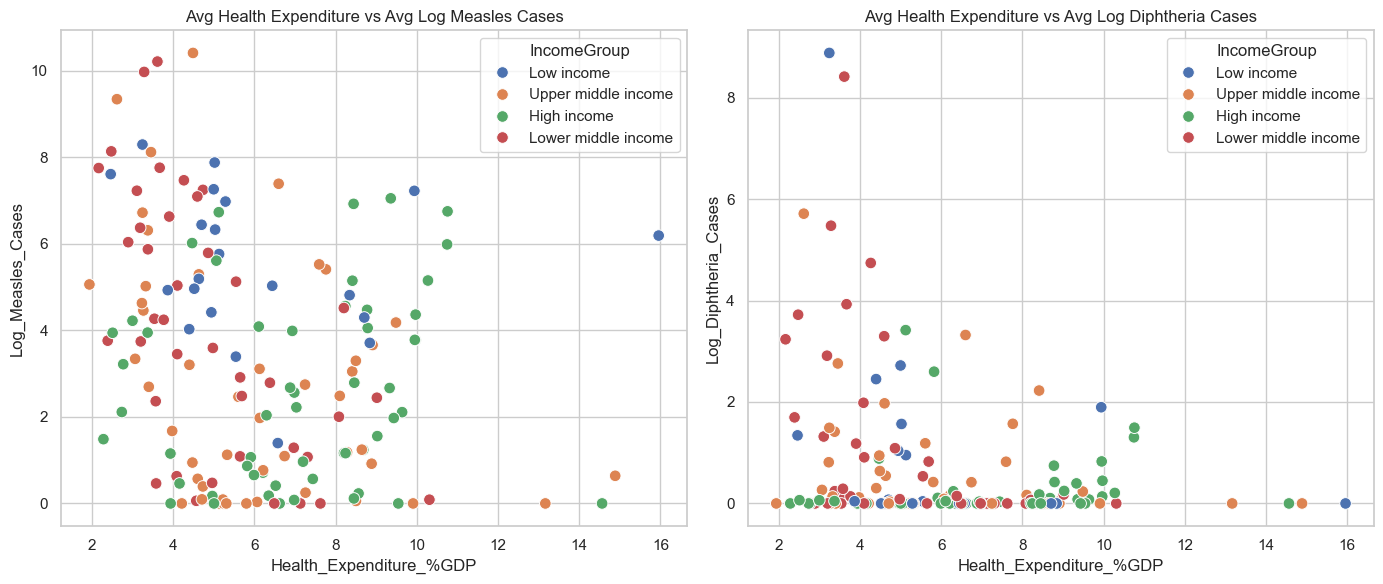

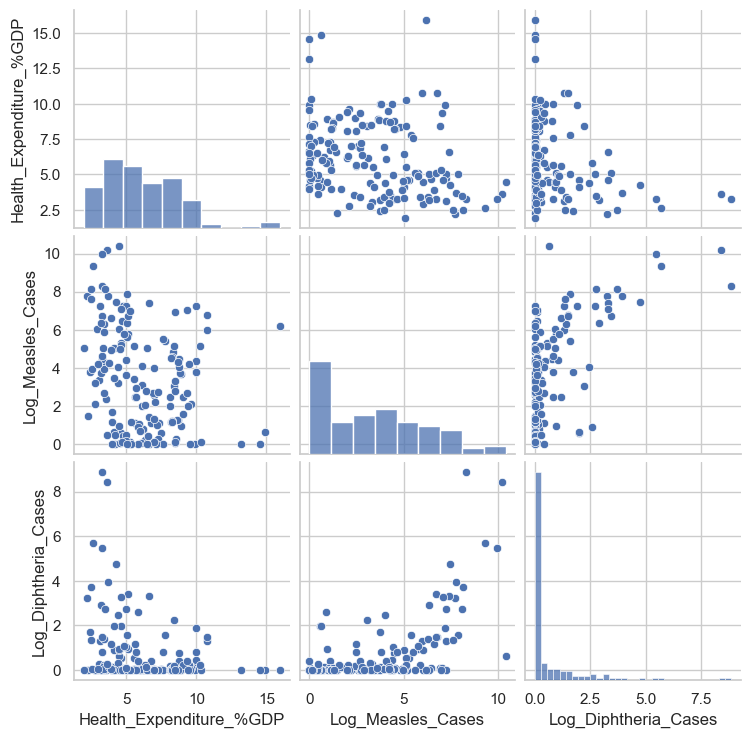

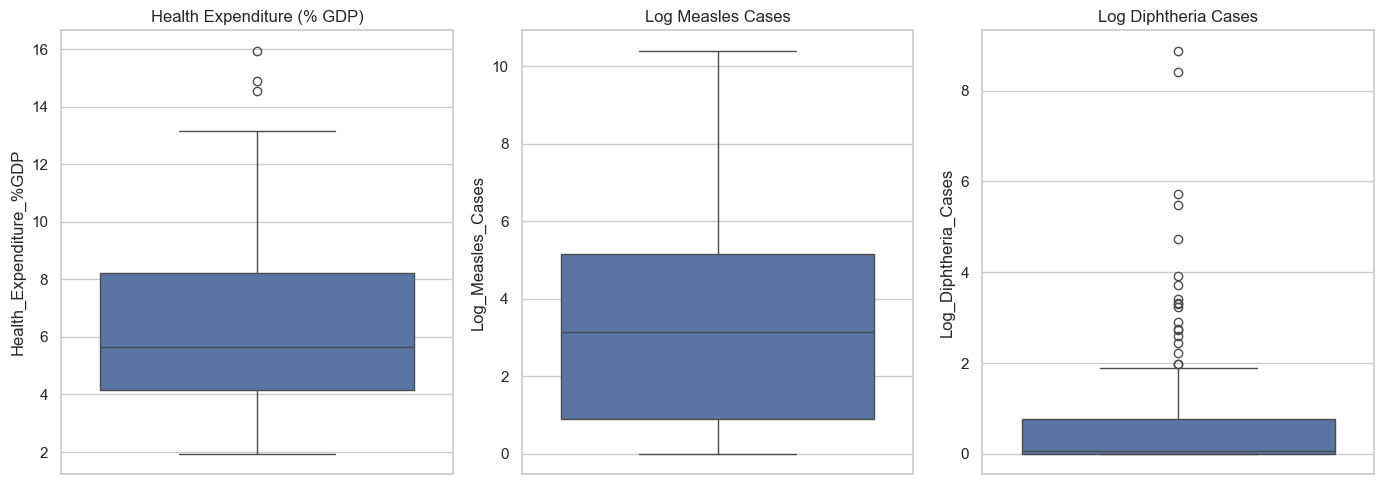

In [4]:
sns.set(style="whitegrid")

# Summary statistics for averaged data
summary_stats = mean_df[[
    "Health_Expenditure_%GDP",
    "Measles_Cases",
    "Diphtheria_Cases",
    "Log_Measles_Cases",
    "Log_Diphtheria_Cases"
]].describe().T

# Add median
summary_stats["median"] = mean_df[[
    "Health_Expenditure_%GDP",
    "Measles_Cases",
    "Diphtheria_Cases",
    "Log_Measles_Cases",
    "Log_Diphtheria_Cases"
]].median().values

summary_stats = summary_stats.round(3)
display(summary_stats)

# scatter Plots 
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=mean_df, x="Health_Expenditure_%GDP", y="Log_Measles_Cases", hue="IncomeGroup", s=70)
plt.title("Avg Health Expenditure vs Avg Log Measles Cases")

plt.subplot(1, 2, 2)
sns.scatterplot(data=mean_df, x="Health_Expenditure_%GDP", y="Log_Diphtheria_Cases", hue="IncomeGroup", s=70)
plt.title("Avg Health Expenditure vs Avg Log Diphtheria Cases")

plt.tight_layout()
plt.show()

sns.pairplot(mean_df[["Health_Expenditure_%GDP", "Log_Measles_Cases", "Log_Diphtheria_Cases"]])

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=mean_df["Health_Expenditure_%GDP"])
plt.title("Health Expenditure (% GDP)")

plt.subplot(1, 3, 2)
sns.boxplot(y=mean_df["Log_Measles_Cases"])
plt.title("Log Measles Cases")

plt.subplot(1, 3, 3)
sns.boxplot(y=mean_df["Log_Diphtheria_Cases"])
plt.title("Log Diphtheria Cases")

plt.tight_layout()
plt.show()




# EDA Continued

- Although this project primarily focuses on exploring the global relationship between health expenditure and disease incidence, visualizing the data by region can provide valuable additional insights like uncovering regional patterns. Regional plots may help reveal localized trends or anomalies that may be masked in a global analysis.

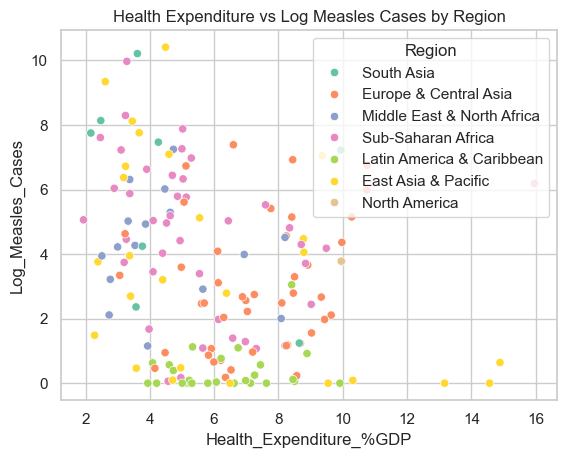

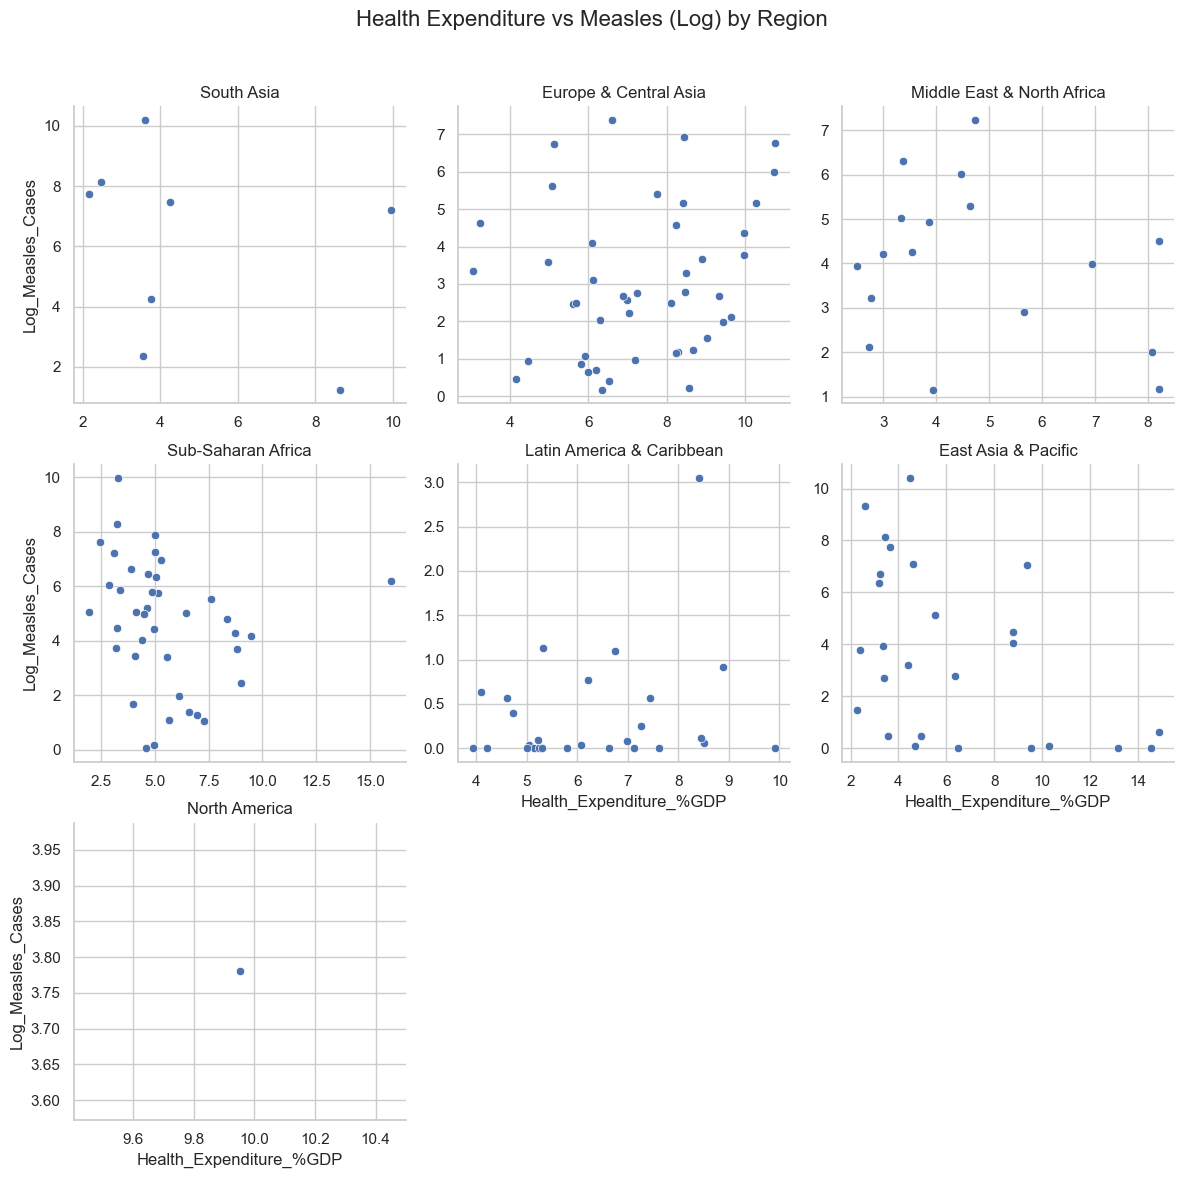

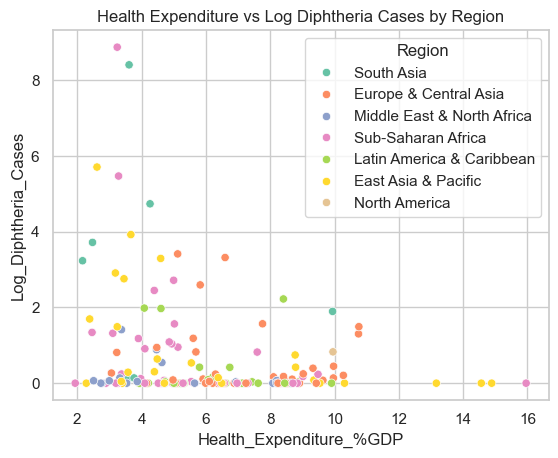

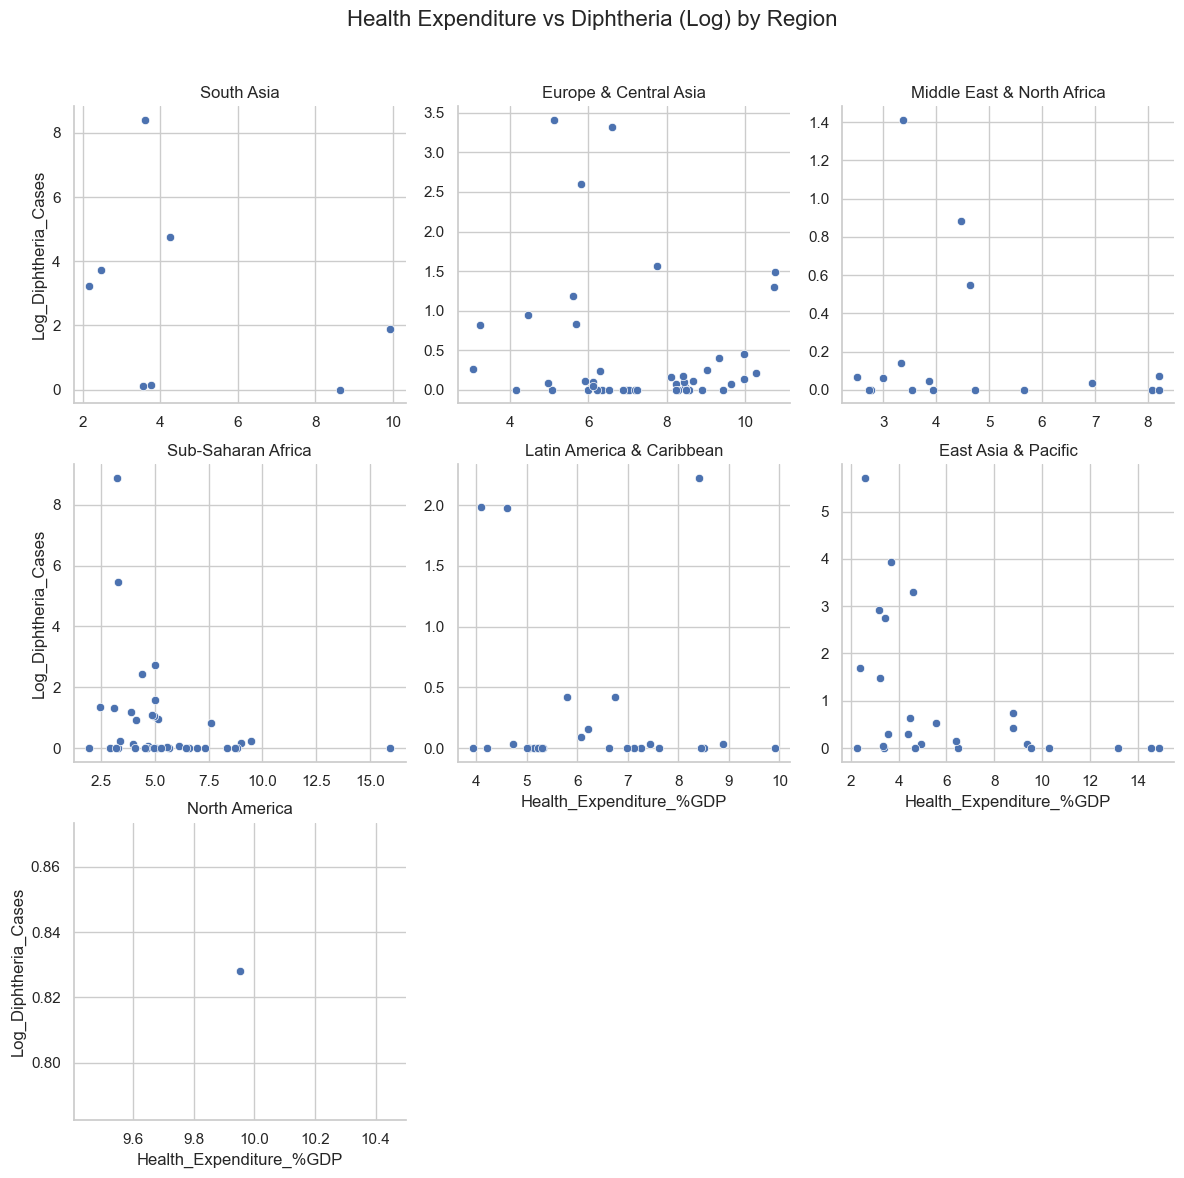

In [11]:
sns.scatterplot(
    x='Health_Expenditure_%GDP',
    y='Log_Measles_Cases',
    hue='Region',
    data=mean_df,
    palette='Set2'
)
plt.title("Health Expenditure vs Log Measles Cases by Region")
plt.show()

g = sns.FacetGrid(mean_df, col="Region", col_wrap=3, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="Health_Expenditure_%GDP", y="Log_Measles_Cases")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Health Expenditure vs Measles (Log) by Region", fontsize=16)
plt.show()


sns.scatterplot(
    x='Health_Expenditure_%GDP',
    y='Log_Diphtheria_Cases',
    hue='Region',
    data=mean_df,
    palette='Set2'
)
plt.title("Health Expenditure vs Log Diphtheria Cases by Region")
plt.show()

g = sns.FacetGrid(mean_df, col="Region", col_wrap=3, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="Health_Expenditure_%GDP", y="Log_Diphtheria_Cases")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Health Expenditure vs Diphtheria (Log) by Region", fontsize=16)
plt.show()

# Hypothesis Testing #

- Conducted Pearson correlation tests to assess the linear relationship between health expenditure and disease incidence.
- Computed correlation coefficients and corresponding p-values for measles and diphtheria cases.
- Used a correlation heatmap to visually interpret the strength and direction of relationships.
- Interpreted results using a 0.05 significance level to determine whether to reject the null hypothesis.

=== Hypothesis Testing Results ===
Health Exp vs Log Measles → r: -0.264 | p-value: 0.0006
Health Exp vs Log Diphtheria → r: -0.284 | p-value: 0.0002


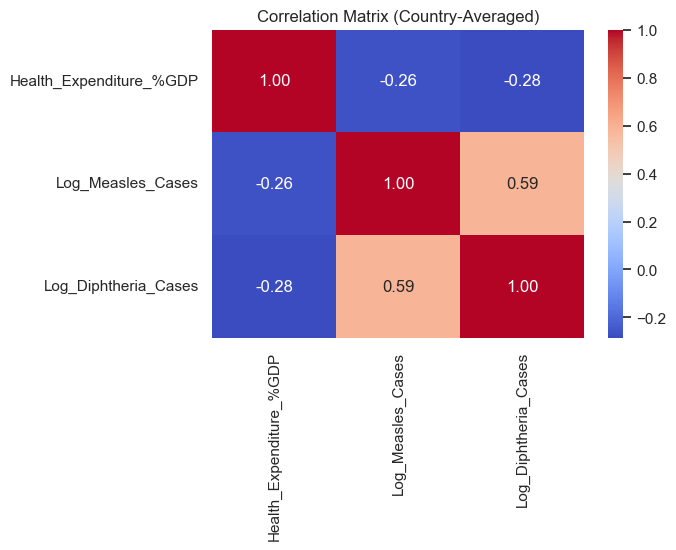


Interpretation:
Measles: p-value = 0.0006 < 0.05 → Reject H0 → Significant negative correlation
Diphtheria: p-value = 0.0002 < 0.05 → Reject H0 → Significant negative correlation


In [6]:

# Pearson correlation tests
corr_measles, pval_measles = pearsonr(mean_df["Health_Expenditure_%GDP"], mean_df["Log_Measles_Cases"])
corr_diphtheria, pval_diphtheria = pearsonr(mean_df["Health_Expenditure_%GDP"], mean_df["Log_Diphtheria_Cases"])

print("=== Hypothesis Testing Results ===")
print("Health Exp vs Log Measles → r:", round(corr_measles, 3), "| p-value:", round(pval_measles, 4))
print("Health Exp vs Log Diphtheria → r:", round(corr_diphtheria, 3), "| p-value:", round(pval_diphtheria, 4))

# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(mean_df[[
    "Health_Expenditure_%GDP",
    "Log_Measles_Cases",
    "Log_Diphtheria_Cases"
]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Country-Averaged)")
plt.show()


# Interpretation of results
alpha = 0.05

print("\nInterpretation:")
if pval_measles < alpha:
    print(f"Measles: p-value = {pval_measles:.4f} < 0.05 → Reject H0 → Significant negative correlation")
else:
    print(f"Measles: p-value = {pval_measles:.4f} ≥ 0.05 → Fail to reject H0 → No significant correlation")

if pval_diphtheria < alpha:
    print(f"Diphtheria: p-value = {pval_diphtheria:.4f} < 0.05 → Reject H0 → Significant negative correlation")
else:
    print(f"Diphtheria: p-value = {pval_diphtheria:.4f} ≥ 0.05 → Fail to reject H0 → No significant correlation")

